In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from googletrans import Translator, constants
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer

In [2]:
train=pd.read_csv(r'Data/train.csv')
train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [3]:
train[train.isnull().any(axis=1)]

,posting_id,image,image_phash,title,label_group


In [4]:
train.shape

(34250, 5)

In [5]:
print('Unique number of posting_id: {}'.format(train.posting_id.unique().shape[0]))
print('Unique number of images: {}'.format(train.image.unique().shape[0]))
print('Unique number of image_phash: {}'.format(train.image_phash.unique().shape[0]))
print('Unique number of title: {}'.format(train.title.unique().shape[0]))
print('Unique number of label_groups: {}'.format(train.label_group.unique().shape[0]))

Unique number of posting_id: 34250
Unique number of images: 32412
Unique number of image_phash: 28735
Unique number of title: 33117
Unique number of label_groups: 11014


In [6]:
train.drop_duplicates(subset=['image','image_phash','title','label_group'],inplace=True)
train.shape

(34250, 5)

***No duplicate records found.***

# **1. Exploratory Data Analysis:**

## ***1.1. Title:***

In [7]:
for title in train.title.values[0:10]:
    print(title)

Paper Bag Victoria Secret
Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE
Maling TTS Canned Pork Luncheon Meat 397 gr
Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
Nescafe \xc3\x89clair Latte 220ml
CELANA WANITA  (BB 45-84 KG)Harem wanita (bisa cod)
Jubah anak size 1-12 thn
KULOT PLISKET SALUR /CANDY PLISKET /WISH KULOT PREMIUM /KULOT PELANGI PREMIUM/HIEKA KULOT
[LOGU] Tempelan kulkas magnet angka, tempelan angka magnet
BIG SALE SEPATU PANTOFEL KULIT KEREN KERJA KANTOR LAKI PRIA COWOK DINAS RESMI FORMAL PESTA KICKERS


In [9]:
detector=Translator()
Languages=[detector.detect(title).lang for title in tqdm(np.random.choice(train.title.values,5000))]

100%|██████████| 5000/5000 [36:43<00:00,  2.27it/s]


In [10]:
Languages=np.array(Languages)
uniq,count=np.unique(Languages,return_counts=True)
np.asarray((uniq,count)).T

array([['en', '4999'],
       ['id', '1']], dtype='<U21')

***We can observe that the title is in multiple languages. It may not be so significant in numbers in 5k randoms samples I checked but you can go through the following discussion on kaggle https://www.kaggle.com/c/shopee-product-matching/discussion/227780 . Some languages has significance to special characters so I cannot preprocess and remove all the special characters before conversion. Also the number have significance in the title as the task here is to find similar products. Same products with different dimensions can be different products.***

In [12]:
translator=Translator()
eng_title=[translator.translate(title).text for title in tqdm(train.title.values)]

100%|██████████| 34250/34250 [4:10:14<00:00,  2.28it/s]  


In [4]:
train_title_trans=pd.DataFrame({'posting_id':train.posting_id.values,'translated_title':translated_title})
train_title_trans.to_csv(r'Data_prepared/train_title_trans.csv',index=False)
train_title_trans=pd.read_csv(r'Data_prepared/train_title_trans.csv')

In [5]:
count=0
for tt in tqdm(train_title_trans.translated_title.values):
    if len(tt.split()) or tt==' ':
        count+1
print('Number of postings with no description: {}'.format(count))

100%|██████████| 34250/34250 [00:00<00:00, 616912.72it/s]

Number of postings with no description: 0


In [6]:
# Check for any html in titles
from bs4 import BeautifulSoup
count=0
for tt in tqdm(train_title_trans.translated_title.values):
    if bool(BeautifulSoup(tt, "html.parser").find()):
        count+1
print('Number of postings with html in description: {}'.format(count))

100%|██████████| 34250/34250 [00:02<00:00, 14821.87it/s]

Number of postings with html in description: 0


***Number cannot be removed from description as numbers may differentiate the products.***

In [7]:
import re
def preprocess(description):
    description=description.lower()
    description=re.sub('[-\n\t]+',' ',description)
    description= re.sub(r"won\'t", "will not",description)
    description=re.sub(r"can\'t", "can not",description)
    description=re.sub(r"n\'t", " not",description)
    description=re.sub(r"\'re", " are",description)
    description=re.sub(r"\'s", " is",description)
    description=re.sub(r"\'d", " would",description)
    description=re.sub(r"\'ll", " will",description)
    description=re.sub(r"\'t", " not",description)
    description=re.sub(r"\'ve", " have",description)
    description=re.sub(r"\'m", " am",description)
    description=re.sub('[^a-z0-9]+',' ',description)
    description=re.sub('\s+',' ',description)
    return description.strip()

In [8]:
preprocessed_title=[preprocess(desp) for desp in tqdm(train_title_trans.translated_title.values)]
preprocessed_title[0:10]

100%|██████████| 34250/34250 [00:00<00:00, 56350.55it/s]


['paper bag victoria secret',
 'double tape 3m vhb 12 mm x 4 5 m original double foam tape',
 'maling tts canned pork luncheon meat 397 gr',
 'short sleeve batik dress random mixed motifs button neck dpt001 00 alhadi character batik',
 'nescafe xc3 x89clair latte 220ml',
 'women is pants bb 45 84 kg harem women can cod',
 'children is robes size 1 12 yrs',
 'knot plisket salur candy plisket wish kulot premium kulot pelangi premium hieka kulot',
 'logu fridge magnet with numbers magnet numbers on it',
 'big sale shoes pantofel cool leather work office men men official official service formal party kickers']

In [10]:
train_preprocessed_title=pd.DataFrame({'posting_id':train.posting_id.values,'preprocessed_title':preprocessed_title})
train_preprocessed_title.head()

,posting_id,preprocessed_title
0,train_129225211,paper bag victoria secret
1,train_3386243561,double tape 3m vhb 12 mm x 4 5 m original doub...
2,train_2288590299,maling tts canned pork luncheon meat 397 gr
3,train_2406599165,short sleeve batik dress random mixed motifs b...
4,train_3369186413,nescafe xc3 x89clair latte 220ml


In [ ]:
train_preprocessed_title.to_csv(r'Data_prepared/train_preprocessed_title.csv',index=False)

In [9]:
train_preprocessed_title=pd.read_csv(r'Data_prepared/train_preprocessed_title.csv')

100%|██████████| 34250/34250 [00:00<00:00, 346466.98it/s]


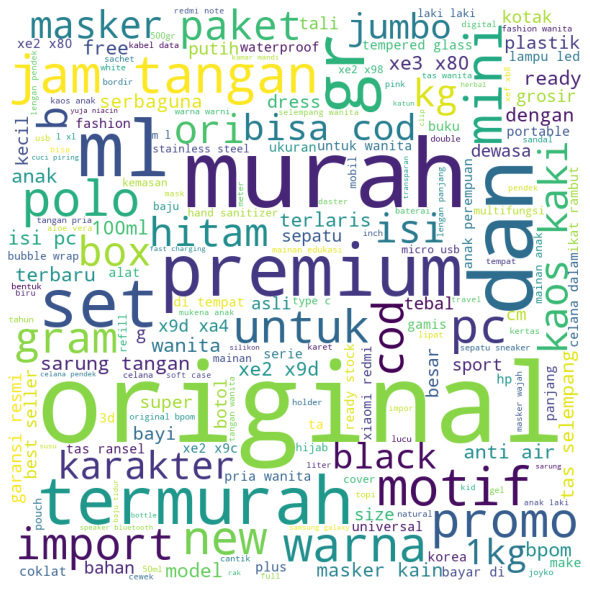

In [26]:
from wordcloud import WordCloud
content=''
for prep_title in tqdm(train_preprocessed_title.preprocessed_title.values):
    for word in prep_title.split():
        content+=word+' '
wordcloud=WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(content)                    
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

100%|██████████| 34250/34250 [00:00<00:00, 1175331.66it/s]


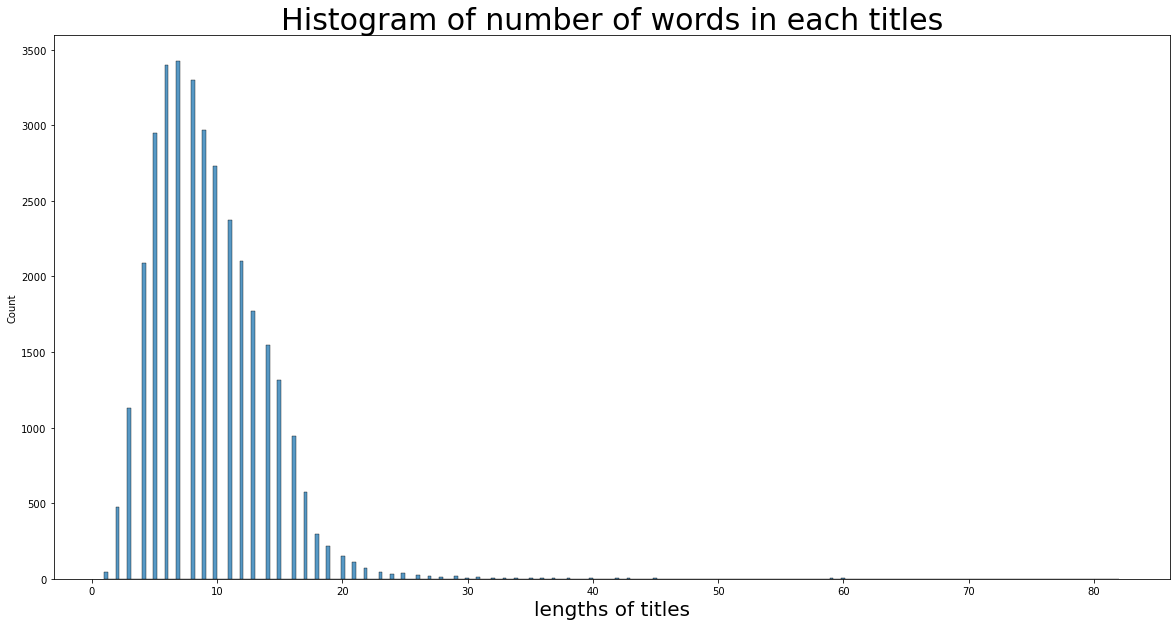

In [20]:
# Number of words in translated and preprocessed titles
lengths=[len(prep_descrip.split()) for prep_descrip in tqdm(train_preprocessed_title.preprocessed_title.values)]
plt.figure(figsize=(20,10))
sns.histplot(lengths,binwidth=0.3)
plt.xlabel('lengths of titles',size=20)
plt.title('Histogram of number of words in each titles',size=30)
plt.show()

In [18]:
for percentile in [5,25,50,75,90,99,99.5,99.9]:
    print('{} percentile: {}'.format(percentile,np.percentile(lengths,percentile)))

5 percentile: 4.0
25 percentile: 6.0
50 percentile: 9.0
75 percentile: 12.0
90 percentile: 15.0
99 percentile: 21.0
99.5 percentile: 25.0
99.9 percentile: 37.0


In [21]:
print('Shortest title length( no. of words ): {}'.format(min(lengths)))
print('longest title length( no. of words ): {}'.format(max(lengths)))
print('Mean of number of words in titles: {}'.format(np.mean(lengths)))
print('Median of number of words in titles: {}'.format(np.median(lengths)))

Shortest title length( no. of words ): 1
longest title length( no. of words ): 82
Mean of number of words in titles: 9.25763503649635
Median of number of words in titles: 9.0


100%|██████████| 34250/34250 [00:00<00:00, 631261.48it/s]


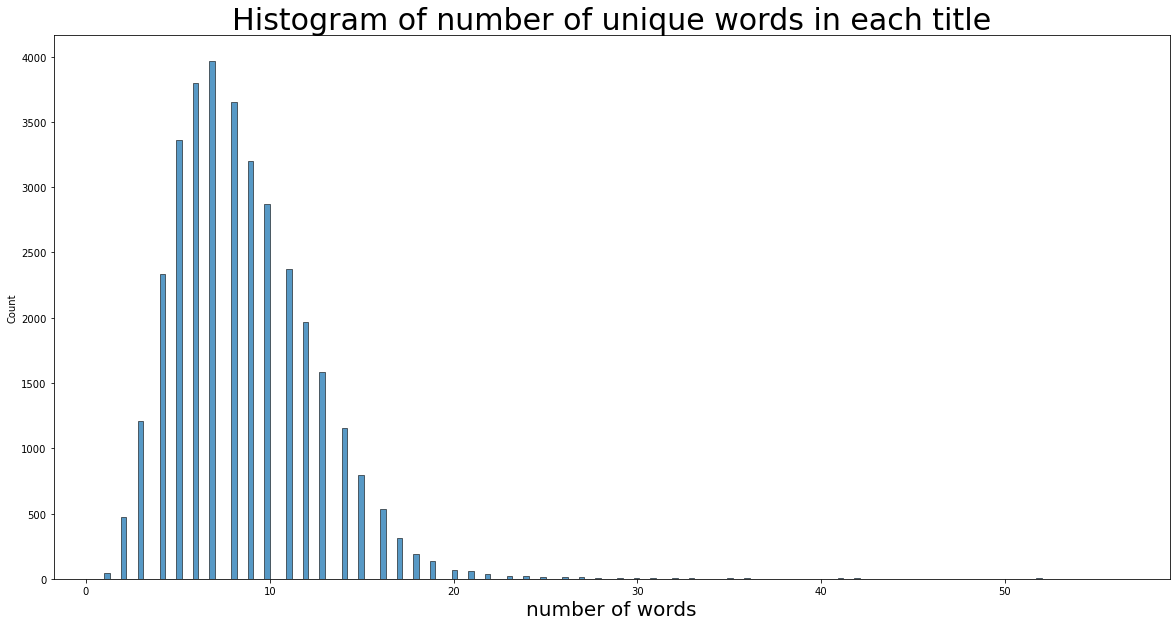

In [22]:
# Number of unique words in translated and preprocessed titles
uniq_lengths=[len(set(prep_descrip.split())) for prep_descrip in tqdm(train_preprocessed_title.preprocessed_title.values)]
plt.figure(figsize=(20,10))
sns.histplot(uniq_lengths,binwidth=0.3)
plt.xlabel('number of words',size=20)
plt.title('Histogram of number of unique words in each title',size=30)
plt.show()

In [23]:
for percentile in [5,25,50,75,90,99,99.5,99.9]:
    print('{} percentile: {}'.format(percentile,np.percentile(uniq_lengths,percentile)))

5 percentile: 3.0
25 percentile: 6.0
50 percentile: 8.0
75 percentile: 11.0
90 percentile: 13.0
99 percentile: 19.0
99.5 percentile: 22.0
99.9 percentile: 32.0


In [24]:
print('Minimum of number of unique words in a title: {}'.format(min(uniq_lengths)))
print('Maximum of number of unique words in a title: {}'.format(max(uniq_lengths)))
print('Mean of number of unique words in titles: {}'.format(np.mean(uniq_lengths)))
print('Median of number of unique words in titles: {}'.format(np.median(uniq_lengths)))

Minimum of number of unique words in a title: 1
Maximum of number of unique words in a title: 56
Mean of number of unique words in titles: 8.5734598540146
Median of number of unique words in titles: 8.0


### ***1.1. Title(text) EDA:***

* *Titles are in Multiple Languages. I checked with random 5000 titles. You can go through this https://www.kaggle.com/c/shopee-product-matching/discussion/227780*

* *There are no postings in dataset without titles and also titles dont have any html.*

* *We can observe through histograms of number of words and number of unique words that there are no high repeating words in titles as there is no significant differences in means and medians. It's logical that title of the products usually don't either have highly repeating words or stopwords. I did not significantly observe any of the stopwords in wordcloud.*

## ***1.2. Image:***

In [3]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [4]:
# dimension of squared images
dims=[]
for img in tqdm(train.image.unique()):
    path='Data/train_images/'+img
    img_arr=img_to_array(load_img(path))
    if img_arr.shape[0]==img_arr.shape[1]:
        dims.append(img_arr.shape[0])
print('Number of unique Images: {}'.format(train.image.unique().shape[0]))
print('Number of squared Images: {}'.format(len(dims)))

100%|██████████| 32412/32412 [05:24<00:00, 99.88it/s] 

Number of unique Images: 32412
Number of squared Images: 32295


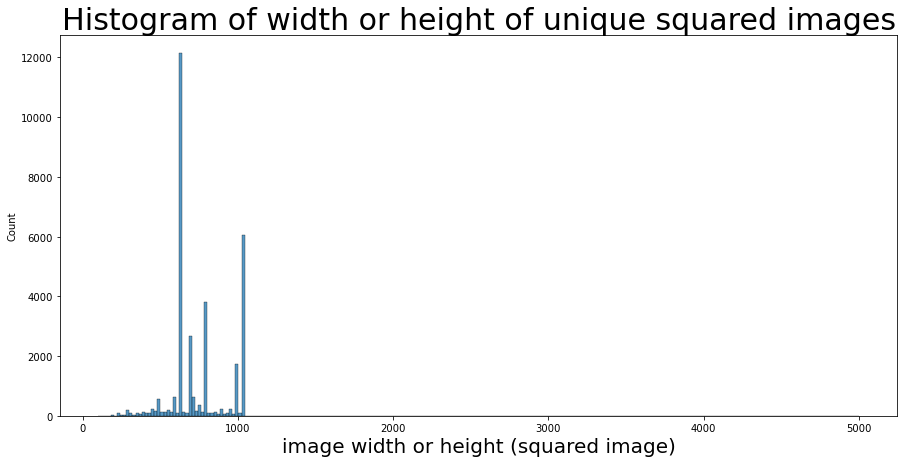

In [38]:
plt.figure(figsize=(15,7))
sns.histplot(dims)
plt.xlabel('image width or height (squared image)',size=20)
plt.title('Histogram of width or height of unique squared images',size=30)
plt.show()

In [5]:
print('Smallest squared dimension: {}x{}'.format(min(dims),min(dims)))
print('Largest squared dimension: {}x{}'.format(max(dims),max(dims)))
print('Median of width or height(Squared image): {}'.format(np.median(dims)))

Smallest squared dimension: 100x100
Largest squared dimension: 5000x5000
Median of width or height(Squared image): 700.0


In [6]:
# top count of images under unique dimensions of squared images in descending order
count_dict={}
for i in set(dims):
    count_dict[i]=dims.count(i)
dict(reversed(sorted(count_dict.items(), key=lambda item: item[1])[-20:]))

{640: 12034,
 1024: 6034,
 800: 3683,
 700: 2537,
 1000: 1464,
 500: 474,
 600: 463,
 720: 449,
 300: 191,
 750: 166,
 1001: 165,
 960: 158,
 900: 155,
 850: 97,
 450: 93,
 225: 90,
 400: 78,
 320: 72,
 554: 65,
 480: 48}

### ***1.2. Basic Image EDA:***

* *More than 99.6% of the images are Square Images(width=height).*

* *More than 56% of images are of dimensions 640x640 and 1024x1024.*

## ***1.3. Label group:***

***Postings under same label group are similar products.***

In [91]:
label_grouped=train[['posting_id','label_group']].groupby('label_group').count().sort_values('posting_id',ascending=False).reset_index()

In [92]:
label_grouped=pd.DataFrame(label_grouped.values,columns=['label_group','count']).head(20)

In [95]:
label_grouped

,label_group,count
0,1163569239,51
1,159351600,51
2,994676122,51
3,3113678103,51
4,3627744656,51
5,1141798720,51
6,562358068,51
7,3206118280,49
8,1733221456,46
9,1166650192,46


***label_group==249114794***

In [96]:
train[train.label_group==249114794]

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
33161,train_2278313361,f83b49a86a0ee8592e3bf0204da3fbdf.jpg,ac63931c3d4b42f6,PAPER BAG VICTORIA SECRET,249114794


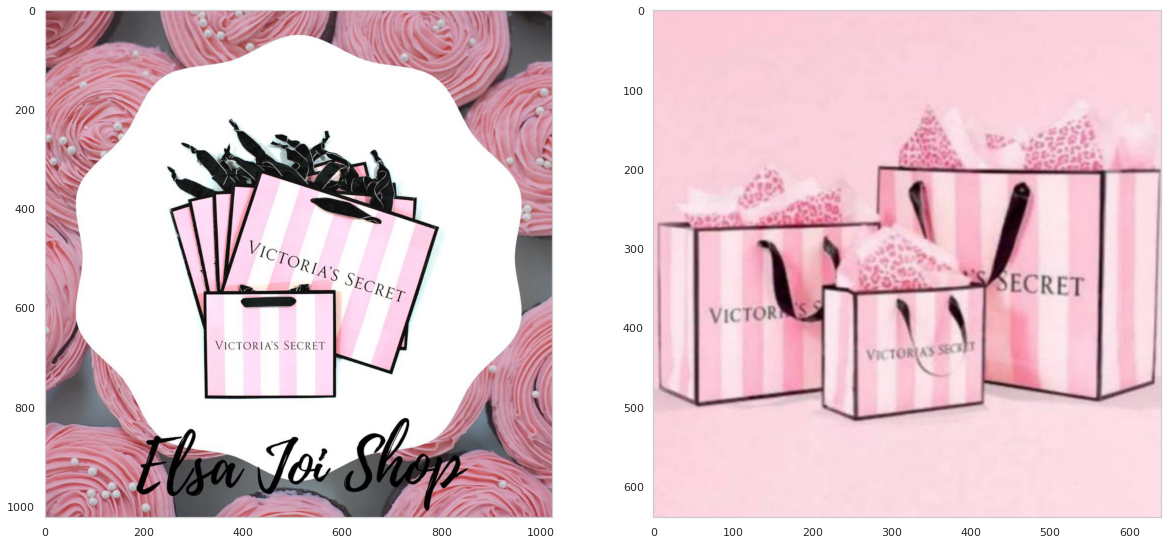

In [106]:
img_1= mpimg.imread(r'Data/train_images/0000a68812bc7e98c42888dfb1c07da0.jpg')
img_2= mpimg.imread(r'Data/train_images/f83b49a86a0ee8592e3bf0204da3fbdf.jpg')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(img_1)
plt.grid(b=None)

plt.subplot(1, 2, 2)
plt.imshow(img_2)
plt.grid(b=None)

plt.show()

***label_group==4093212188***

In [128]:
train[train.label_group==4093212188]

,posting_id,image,image_phash,title,label_group
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
11027,train_3342059966,52f5b2e6f6647325817eb99db17709f0.jpg,a829ad16d7cec274,DASTER PIYAMA KATUN JEPANG(TIDAK BISA PILIH MO...,4093212188


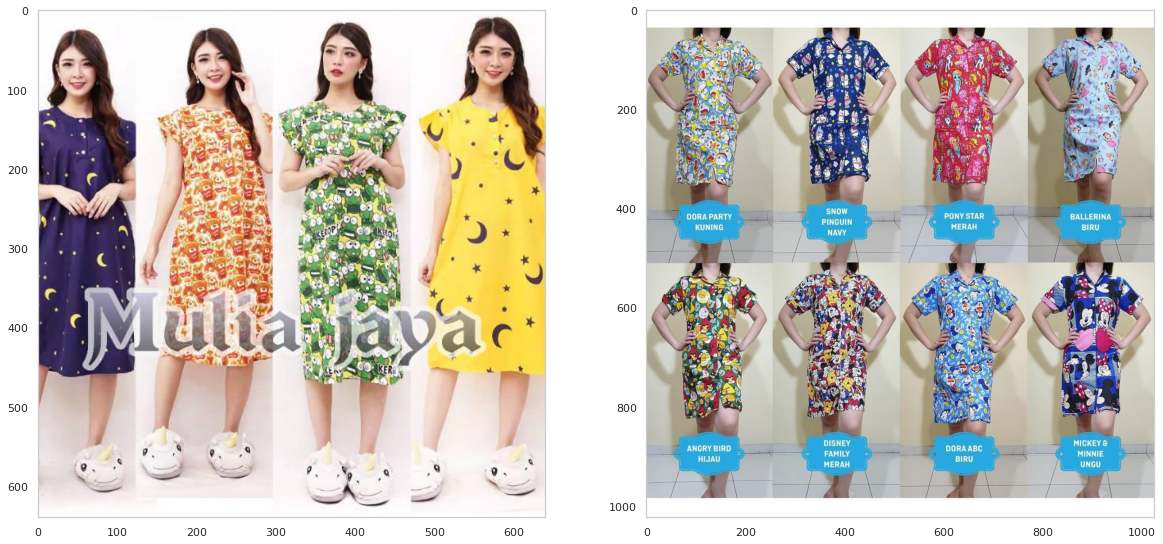

In [129]:
img_1= mpimg.imread(r'Data/train_images/00117e4fc239b1b641ff08340b429633.jpg')
img_2= mpimg.imread(r'Data/train_images/52f5b2e6f6647325817eb99db17709f0.jpg')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(img_1)
plt.grid(b=None)

plt.subplot(1, 2, 2)
plt.imshow(img_2)
plt.grid(b=None)

plt.show()

### ***1.3. Label group:***

* *There are more than 10k unique label groups and 51 is the highest number of postings under a label.*

* *Can we say label group is the ground truth as we observe similar products under a label group? Let's also explore image_phash before concluding that.*

## ***1.4. Image phash:***

In [7]:
# Number of images(top-20) under image_phash in descending order
ph=[i for i in train.image_phash.values]
dic={}
for i in set(ph):
    dic[i]=ph.count(i)
dict(reversed(sorted(dic.items(), key=lambda item: item[1])[-20:]))

{'fad28daa2ad05595': 26,
 'd0c0ea37bd9acce0': 20,
 'be12e12f9ec1e198': 17,
 'f6d98134b904b56b': 16,
 'e992966d4ba49761': 16,
 'ba96cc48cc63c56b': 14,
 'def6e14b4a398885': 13,
 '84563f696135c79a': 13,
 'ada4c4781f93686e': 12,
 'ce2fa4d3959a51b0': 12,
 'bb13e24edd48d02e': 12,
 'ad29e81e92b295b5': 12,
 'fbea84056cb86b43': 12,
 '9e8966c3ad4ecc62': 12,
 'b08d4fb16a1b8d5a': 11,
 'f7b9c25864433966': 11,
 '9fc9f030e83e850f': 11,
 'bc4aa5a5de34d2e0': 11,
 'aeedc4d48b52911b': 11,
 'bc9963c6c6c23369': 10}

In [125]:
train[train.image_phash=='d0c0ea37bd9acce0'] #checking an image_phash

,posting_id,image,image_phash,title,label_group
1651,train_3068759534,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,BUBBLE PACK UNTUK PACKING TAMBAHAN 1BUBBLE UNT...,4198148727
1652,train_1049463374,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,BUBBLE WARP,2403374241
1653,train_2420615645,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,BUBBLE WRAP - EXTRA PACKING UNTUK BARANG ANDA,4198148727
1654,train_1236710293,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Bubble Warp Pengaman Pengiriman,4198148727
1655,train_443869273,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Bubble Wrap,4198148727
1656,train_1381575164,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Bubble Wrap untuk ekstra packaging,4198148727
1657,train_2085280992,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Buble Wrap,4198148727
1658,train_4226152332,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,EXTRA BUBBLE WRAP UNTUK PACKING,2403374241
1659,train_1437764574,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Extra Bubble Wrap,4198148727
1660,train_3993385953,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Extra Bubble Wrap Pengaman Packingan,2403374241


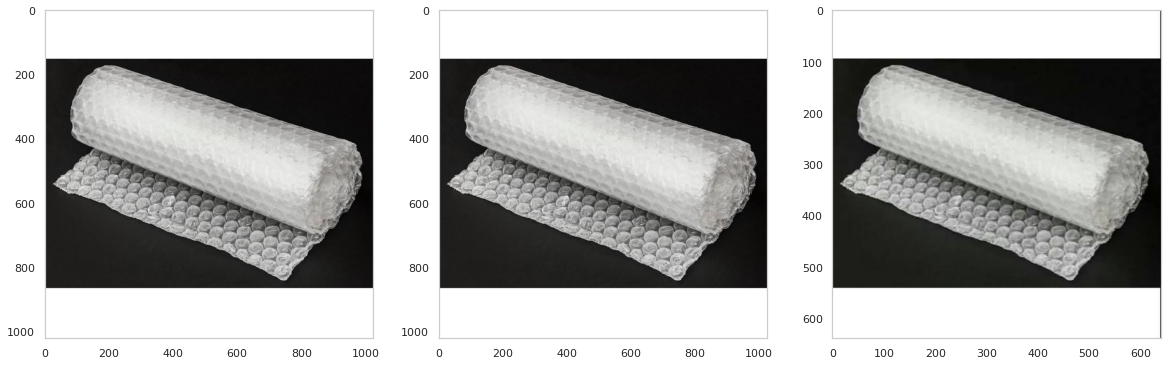

In [126]:
img_1= mpimg.imread(r'Data/train_images/0cca4afba97e106abd0843ce72881ca4.jpg') #train_3068759534 #Label_group=4198148727
img_2= mpimg.imread(r'Data/train_images/0cca4afba97e106abd0843ce72881ca4.jpg') #train_1049463374 #Label_group=2403374241
img_3= mpimg.imread(r'Data/train_images/2a8c24726ee9a1446a65325d65f66659.jpg') #train_3095376889 #Label_group=1960893869

plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.imshow(img_1)
plt.grid(b=None)

plt.subplot(1, 3, 2)
plt.imshow(img_2)
plt.grid(b=None)

plt.subplot(1, 3, 3)
plt.imshow(img_3)
plt.grid(b=None)

plt.show()

***We can observe that different images(file names) have same image phash and we can consider like images with same phash as similar images. But we can also observe that for the above 3 images the label groups are different. Let's check label groups 4198148727, 2403374241, 1960893869 in particular.***

***label_group==4198148727***

In [133]:
train[train.label_group==4198148727]

,posting_id,image,image_phash,title,label_group
1651,train_3068759534,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,BUBBLE PACK UNTUK PACKING TAMBAHAN 1BUBBLE UNT...,4198148727
1653,train_2420615645,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,BUBBLE WRAP - EXTRA PACKING UNTUK BARANG ANDA,4198148727
1654,train_1236710293,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Bubble Warp Pengaman Pengiriman,4198148727
1655,train_443869273,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Bubble Wrap,4198148727
1656,train_1381575164,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Bubble Wrap untuk ekstra packaging,4198148727
1657,train_2085280992,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Buble Wrap,4198148727
1659,train_1437764574,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Extra Bubble Wrap,4198148727
1661,train_493140267,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,PACKING TAMBAHAN BUBBLE WRAP,4198148727
1662,train_419018435,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Tambahan Bubble Wrap,4198148727
1663,train_2514153495,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Tambahan Bubble wrap / Plastik Bubble Pelindun...,4198148727


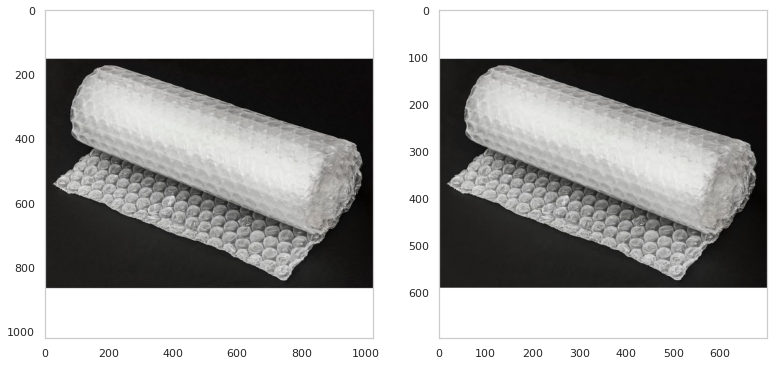

In [136]:
img_1= mpimg.imread(r'Data/train_images/0cca4afba97e106abd0843ce72881ca4.jpg') 
img_2= mpimg.imread(r'Data/train_images/97579081385d8dd3bbee151ff0bf5cb1.jpg') 

plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.imshow(img_1)
plt.grid(b=None)

plt.subplot(1, 3, 2)
plt.imshow(img_2)
plt.grid(b=None)


plt.show()

***label_group==2403374241***

In [134]:
train[train.label_group==2403374241]

,posting_id,image,image_phash,title,label_group
909,train_3284960524,071d2deb4a8cad2c6ae930b96cd40664.jpg,b434c193c66dccc7,Extra Bubble Wrap dan Dus Packing,2403374241
1652,train_1049463374,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,BUBBLE WARP,2403374241
1658,train_4226152332,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,EXTRA BUBBLE WRAP UNTUK PACKING,2403374241
1660,train_3993385953,0cca4afba97e106abd0843ce72881ca4.jpg,d0c0ea37bd9acce0,Extra Bubble Wrap Pengaman Packingan,2403374241
4567,train_1010043803,2268eabcdc99889e3939f4f9f8cd65a8.jpg,9abd65c69e2899b0,Bubble Wrap,2403374241
13226,train_24138636,63aed41dc08d30aaf3285fe598da64d1.jpg,e6cc9d33c09b718c,BUBBLE WRAP tambahan untuk paket pengiriman,2403374241
13227,train_276173105,63aed41dc08d30aaf3285fe598da64d1.jpg,e6cc9d33c09b718c,Plastik Bubble (bubble wrap) untuk Packing Tam...,2403374241
14570,train_382020659,6db2474aa1cc1929877f0d76396e8451.jpg,e6cc9d33c09b70cc,ACC055 BUBBLE WRAP,2403374241
14571,train_1785845140,6db2474aa1cc1929877f0d76396e8451.jpg,e6cc9d33c09b70cc,BUBBLE WRAP UNTUK PACKING TAMBAHAN,2403374241
14572,train_985681332,6db2474aa1cc1929877f0d76396e8451.jpg,e6cc9d33c09b70cc,Bubble Wrap / Packing Tambahan,2403374241


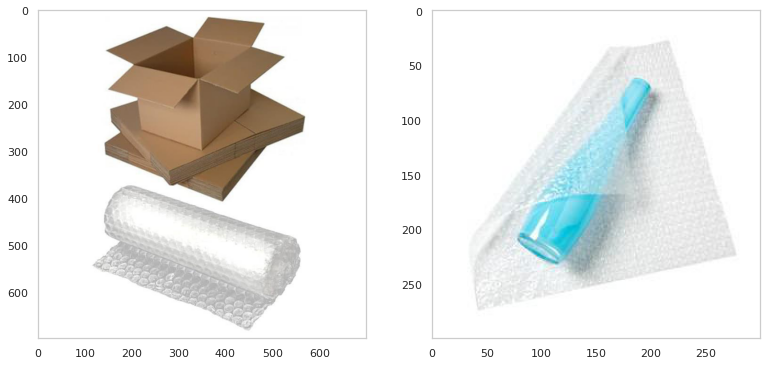

In [137]:
img_1= mpimg.imread(r'Data/train_images/071d2deb4a8cad2c6ae930b96cd40664.jpg') 
img_2= mpimg.imread(r'Data/train_images/63aed41dc08d30aaf3285fe598da64d1.jpg') 

plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.imshow(img_1)
plt.grid(b=None)

plt.subplot(1, 3, 2)
plt.imshow(img_2)
plt.grid(b=None)


plt.show()

***label_group==1960893869***

In [135]:
train[train.label_group==1960893869]

,posting_id,image,image_phash,title,label_group
1639,train_3338330076,0cb3efecec7c834ea3078b0feb17b6ef.jpg,d0c0ea3f9d9acce0,Buble wrap,1960893869
5641,train_3095376889,2a8c24726ee9a1446a65325d65f66659.jpg,d0c0ea37bd9acce0,Packing Tambahan Bubble Wrap/Kardus Bekas,1960893869
11747,train_3763288677,584cc2a3204dbb073d96cce27d603193.jpg,d0c0ea3eb5b81acd,Buble wrap,1960893869


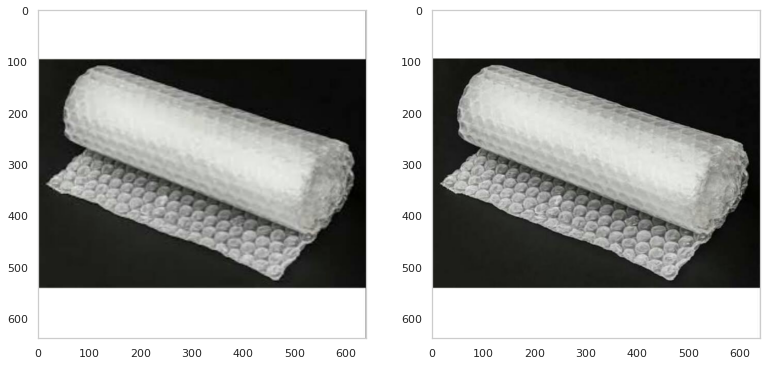

In [138]:
img_1= mpimg.imread(r'Data/train_images/0cb3efecec7c834ea3078b0feb17b6ef.jpg') 
img_2= mpimg.imread(r'Data/train_images/2a8c24726ee9a1446a65325d65f66659.jpg') 

plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.imshow(img_1)
plt.grid(b=None)

plt.subplot(1, 3, 2)
plt.imshow(img_2)
plt.grid(b=None)


plt.show()

### ***1.4. Image phash:***

* *We can observe that Images with same image_phash belong to different label groups but when checked those images across label groups it's evident that those images are same.*


* *We can observe that images under label groups 4198148727, 2403374241, 1960893869 are of similar products. Their titles also convey the same.*


* *So can we consider different label groups which share the image_phash are same products? No. In the following discussion on kaggle it is evident that images with completely different products can also have same image phash. https://www.kaggle.com/c/shopee-product-matching/discussion/225257*

***Can Label group itself be considered as ground truth? After exploring image_phash we can see that label groups 4198148727, 2403374241, 1960893869 contain similar products and they are related with image phash. But from the kaggle discussion ( https://www.kaggle.com/c/shopee-product-matching/discussion/225257 ) we can see that images with different products also have same image phash. So image phash cannot be considered as ground truth. It's no where evident that products under a label group are dis-similar. Then what about different label groups having same products as we observed? This may be because Shopee operates across the countries in South Asia or they may be same products with different brands. This is just an assumption as Shopee did not provide any information about this. So we cannot cannot consider label group as exact ground truth and this problem should be solved in Un-supervised approach.***